In [212]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import yfinance as yf
import matplotlib.pyplot as plt

In [108]:
def download_and_prepare_data(ticker='MSTR', start_date='2020-01-01', end_date=None, window=20):
    df = yf.download(ticker, start=start_date, end=end_date)
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['daily_vol'] = df['log_return'].rolling(window=window).std()
    df['daily_variance'] = df['daily_vol']**2
    df['anaulized_vol'] = df['daily_vol'] * np.sqrt(252)
    df = df.dropna()
    return df

In [110]:
df = download_and_prepare_data('MSTR', '2020-01-01')

[*********************100%***********************]  1 of 1 completed


# Base Model
We use Ornstein-Uhlenbeck + Jump to model volatility
$$
d \nu(t) = \kappa(\theta - \nu(t) ) dt + \xi \sqrt{\nu(t)} dW_{t}^\nu + J_t dN_t
$$

then put it into the black-Scholes:
$$
dS(t) = S(t)\cdot((r-q)dt + \sqrt{\nu(t)} dW_t^{S}).
$$

In [113]:
def estimate_initial_parameters(variance_series):
    try:
        theta_est = variance_series.median()
        xi_est = variance_series.std() / np.sqrt(max(variance_series.mean(), 1e-10))
        autocorr = max(0.01, min(variance_series.autocorr(lag=1), 0.99))
        dt = 1/252
        kappa_est = -np.log(autocorr) / dt
        kappa_est = max(0.1, min(kappa_est, 50))
        v0_est = variance_series.iloc[0]
        
        # Define "large Jump" as changes beyond 2 standard deviations for change in variance
        variance_changes = variance_series.diff().dropna()
        threshold = 2 * variance_changes.std()
        jumps = variance_changes[abs(variance_changes) > threshold]
        
        if len(jumps) > 0:
            lambda_est = len(jumps) / len(variance_changes)
            mu_J_est = jumps.mean()
            sigma_J_est = max(jumps.std(), 1e-6)  # Ensure positive
        else:
            lambda_est = 0.01
            mu_J_est = 0.0001
            sigma_J_est = 0.0005
        
        return {
            'kappa': kappa_est,
            'theta': theta_est,
            'xi': xi_est,
            'v0': v0_est,
            'lambda': lambda_est,
            'mu_J': mu_J_est,
            'sigma_J': sigma_J_est
        }
    except Exception as e:
        print(f"Error estimating parameters: {e}")
        return {
            'kappa': 2.0,
            'theta': 0.04,
            'xi': 0.3,
            'v0': 0.04,
            'lambda': 0.01,
            'mu_J': 0.0001,
            'sigma_J': 0.0005
        }

In [115]:
param_estimates = estimate_initial_parameters(df['daily_variance'])
for X in param_estimates:
    print(f'{X}: {param_estimates[X]:.2e}')

kappa: 4.63e+00
theta: 2.59e-03
xi: 5.18e-02
v0: 2.21e-04
lambda: 4.39e-02
mu_J: 4.77e-05
sigma_J: 2.47e-03


Discretize everything(Euler-Maruyama):
$$
\nu_{t+\Delta t} = \nu_t + \kappa(\theta - \nu_t ) \Delta t + \xi \sqrt{\mathrm{max}(\nu_t,0)} \sqrt{\Delta t} Z_\nu + J I
$$
where:
1) $Z_\nu \sim \mathcal{N}(0, 1)$ is a standard normal random variable
2) $I \sim \text{Bernoulli}(\lambda \Delta t)$ indicates whether a jump occurs
3) $J \sim \mathcal{N}(\mu_J, \sigma_J^2)$ is the jump size if a jump occurs
4) $\max(\nu_i, 0)$ ensures the variance is non-negative for the square root

For the price:
$$
S_{t+\Delta t} = S_t \mathrm{exp} \left( (r-q -\frac{1}{2} \nu_t) \Delta t + \sqrt{\mathrm{max}(\nu_t,0)} \sqrt{\Delta t} Z_{S} \right)
$$
where $Z_S = \rho Z_\nu + \sqrt{1-\rho^2}Z$ with $Z \sim \mathcal{N}(0, 1)$ independent of $Z_\nu$

In [119]:
def Get_rho(df):
    log_return = df['log_return'].iloc[1:].values
    Delta_var = (df['daily_variance'] - df['daily_variance'].shift(1)).dropna().values
    return np.corrcoef(log_return,Delta_var)[0,1]

In [121]:
def Sim_price(df, param_estimates, N_sims=1000, time_steps=20, dt=1/252, mu=0.04):

    kappa = param_estimates['kappa']
    theta = param_estimates['theta']
    xi = param_estimates['xi']
    lambda_jump = param_estimates['lambda']
    mu_J = param_estimates['mu_J']       
    sigma_J = param_estimates['sigma_J'] 
    
    rho = Get_rho(df)
    S_paths = []
    nu_paths = []
    S_0 = df['Close'].iloc[-1]
    v_0 = df['daily_variance'].iloc[-1]
    
    for i in range(N_sims):
        # GMB
        Z_nu = np.random.normal(0, 1, time_steps)
        Z = np.random.normal(0, 1, time_steps)
        Z_S = rho*Z_nu + np.sqrt(1-rho**2)*Z
        
        # jump process
        # occurrences = Bernoulli trials with probability lambda_jump * dt
        jump_occurs = np.random.binomial(1, lambda_jump, time_steps)
        # magnitudes = Normal distribution (mu_J,sigma_J)
        jump_magnitude = np.random.normal(mu_J, sigma_J, time_steps)
        jump_effect = jump_occurs * jump_magnitude
        
        nu_t = [v_0]
        S_t = [S_0]
        
        for j in range(1, time_steps):
            nu_t_Delta_t = nu_t[j-1] + kappa*(theta-nu_t[j-1])*dt + \
                           xi*np.sqrt(max(nu_t[j-1], 1e-10))*np.sqrt(dt)*Z_nu[j-1] + \
                           jump_effect[j-1]
            
            # Ensure variance stays positive
            nu_t_Delta_t = max(nu_t_Delta_t, 1e-10)
            S_t_Delta_t = S_t[j-1]*np.exp((mu-1/2*nu_t[j-1])*dt + \
                                         np.sqrt(max(nu_t[j-1], 1e-10))*np.sqrt(dt)*Z_S[j-1])
            
            nu_t.append(nu_t_Delta_t)
            S_t.append(S_t_Delta_t)
        
        nu_paths.append(nu_t)
        S_paths.append(S_t)
    
    return S_paths, nu_paths

In [166]:
S,nu = Sim_price(df,param_estimates,N_sims=100)

In [168]:
def analyze_simulations(S_paths, nu_paths, df, param_estimates, dt=1/252):

    S_paths_array = np.array(S_paths)
    nu_paths_array = np.array(nu_paths)

    time_steps = S_paths_array.shape[1]
    mean_price_path = np.mean(S_paths_array, axis=0)
    median_price_path = np.median(S_paths_array, axis=0)
    lower_price_quantile = np.quantile(S_paths_array, 0.05, axis=0)
    upper_price_quantile = np.quantile(S_paths_array, 0.95, axis=0)
    
    mean_price_path = np.ravel(mean_price_path)
    median_price_path = np.ravel(median_price_path)
    lower_price_quantile = np.ravel(lower_price_quantile)
    upper_price_quantile = np.ravel(upper_price_quantile)
    
    # Vol
    vol_paths = np.sqrt(nu_paths_array) * np.sqrt(252)  # Annualized
    mean_vol_path = np.mean(vol_paths, axis=0)
    median_vol_path = np.median(vol_paths, axis=0)
    lower_vol_quantile = np.quantile(vol_paths, 0.05, axis=0)
    upper_vol_quantile = np.quantile(vol_paths, 0.95, axis=0)

    mean_vol_path = np.ravel(mean_vol_path)
    median_vol_path = np.ravel(median_vol_path)
    lower_vol_quantile = np.ravel(lower_vol_quantile)
    upper_vol_quantile = np.ravel(upper_vol_quantile)
    
    # Generate future dates
    last_date = df.index[-1]
    future_dates = [last_date + pd.Timedelta(days=int(i*dt*365)) for i in range(time_steps)]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    ax1.plot(future_dates, mean_price_path, 'b-', label='Mean Price Path')
    ax1.plot(future_dates, median_price_path, 'g--', label='Median Price Path')
    ax1.fill_between(future_dates, lower_price_quantile, upper_price_quantile, 
                   color='b', alpha=0.2, label='90% Confidence Interval')
    
    past_dates = df.index[-min(252, len(df)):]
    past_prices = df['Close'].iloc[-min(252, len(df)):].values  # Add .values to ensure 1D
    ax1.plot(past_dates, past_prices, 'k-', label='Historical Data')
    
    ax1.set_title('Price Simulation with Heston-Jump Model')
    ax1.set_ylabel('Price')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='best')
    
    
    # Plot volatility paths
    ax2.plot(future_dates, mean_vol_path * 100, 'r-', label='Mean Volatility Path')
    ax2.plot(future_dates, median_vol_path * 100, 'm--', label='Median Volatility Path')
    ax2.fill_between(future_dates, lower_vol_quantile * 100, upper_vol_quantile * 100, 
                   color='r', alpha=0.2, label='90% Confidence Interval')
    
    past_vol = np.sqrt(df['daily_variance'].iloc[-min(252, len(df)):].values) * np.sqrt(252) * 100
    ax2.plot(past_dates, past_vol, 'k-', label='Historical Volatility')
    
    theta = param_estimates['theta']
    ax2.axhline(y=np.sqrt(theta) * np.sqrt(252) * 100, color='g', linestyle='--', 
              label=f'Long-run Volatility ({np.sqrt(theta) * np.sqrt(252) * 100:.1f}%)')
    
    ax2.set_title('Volatility Simulation with Heston-Jump Model')
    ax2.set_ylabel('Volatility (%)')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='best')
    
    plt.tight_layout()
    plt.show()
    
    # Print expected price and volatility statistics
    print(f"Expected price after {time_steps*dt*252:.0f} trading days: {mean_price_path[-1]:.2f}")
    print(f"Median expected price: {median_price_path[-1]:.2f}")
    print(f"90% confidence interval: [{lower_price_quantile[-1]:.2f}, {upper_price_quantile[-1]:.2f}]")
    print(f"Initial volatility: {np.sqrt(nu_paths_array[0, 0])*np.sqrt(252):.2%}")
    print(f"Expected volatility: {mean_vol_path[-1]:.2%}")
    print(f"Long-run volatility level: {np.sqrt(theta)*np.sqrt(252)*100:.2f}%")
    
    # Calculate probability of price increase
    probability_increase = np.mean(S_paths_array[:, -1] > S_paths_array[:, 0])
    print(f"Probability of price increase: {probability_increase*100:.1f}%")
    
    return {
        'mean_price': mean_price_path,
        'median_price': median_price_path,
        'price_CI': (lower_price_quantile, upper_price_quantile),
        'mean_vol': mean_vol_path,
        'future_dates': future_dates
    }

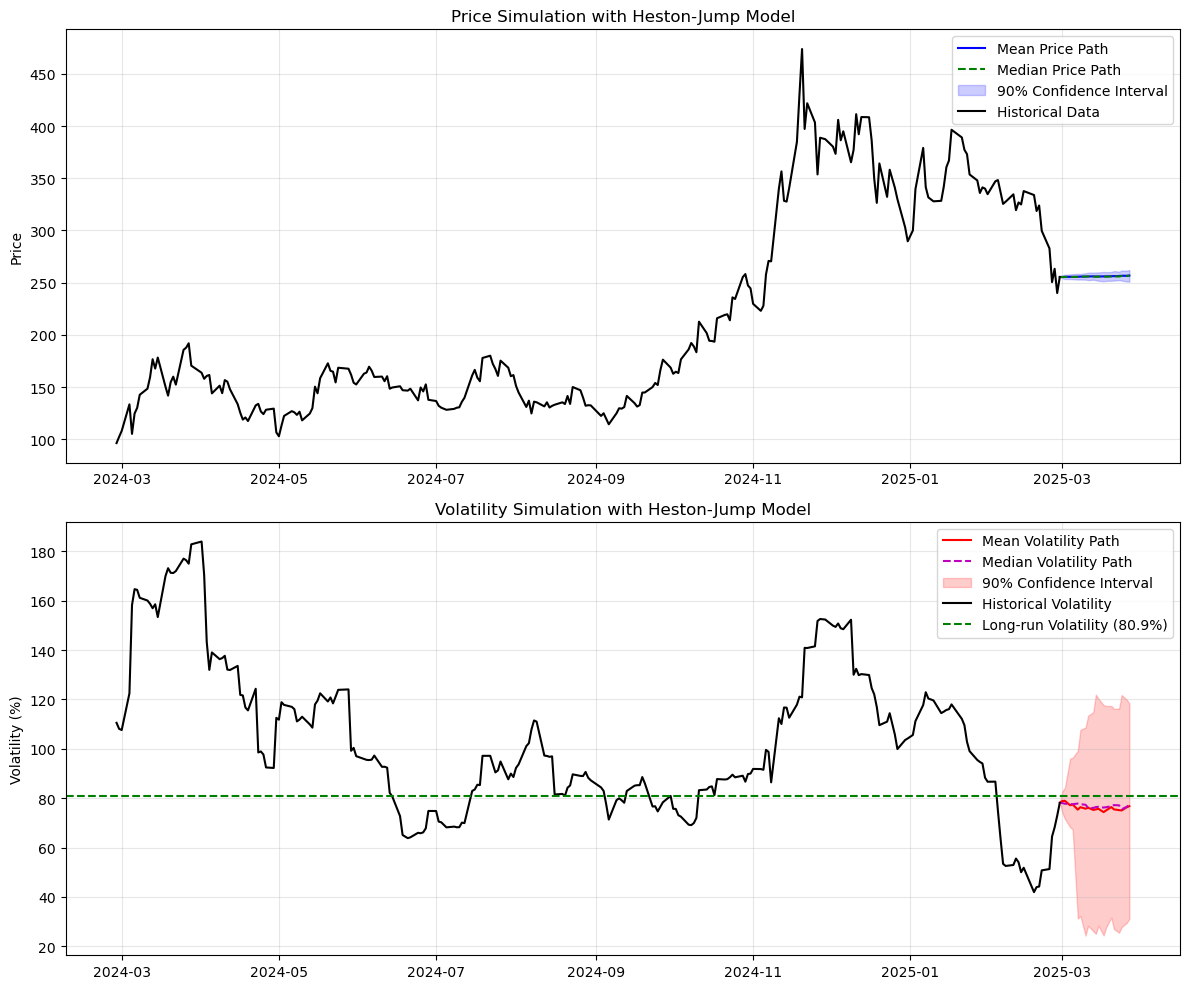

Expected price after 20 trading days: 256.80
Median expected price: 256.74
90% confidence interval: [251.00, 262.15]
Initial volatility: 78.10%
Expected volatility: 76.75%
Long-run volatility level: 80.86%
Probability of price increase: 64.0%


In [170]:
result = analyze_simulations(S, nu, df, param_estimates)

# Option pricing
Now we price the option using risk-neutral measure
$$
V =  e^{-r T} \cdot \mathbb{E}[\mathrm{payoffs}]
$$

In [ ]:
def implied_volatility(price, S, K, T, r, q, option_type):
    """Calculate implied volatility using bisection method"""
    
    def d1(sigma):
        return (np.log(S/K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    
    def d2(sigma):
        return d1(sigma) - sigma * np.sqrt(T)
    
    def bs_price(sigma):
        if option_type == 'call':
            return S * np.exp(-q * T) * norm.cdf(d1(sigma)) - K * np.exp(-r * T) * norm.cdf(d2(sigma))
        else:
            return K * np.exp(-r * T) * norm.cdf(-d2(sigma)) - S * np.exp(-q * T) * norm.cdf(-d1(sigma))
    
    def objective(sigma):
        return bs_price(sigma) - price
    
    sigma_low = 0.001
    sigma_high = 2.0
    
    if objective(sigma_low) * objective(sigma_high) > 0:
        return np.nan
    
    max_iterations = 100
    tolerance = 1e-6
    
    for i in range(max_iterations):
        sigma_mid = (sigma_low + sigma_high) / 2
        obj_mid = objective(sigma_mid)
        
        if abs(obj_mid) < tolerance:
            return sigma_mid
        
        if objective(sigma_low) * obj_mid < 0:
            sigma_high = sigma_mid
        else:
            sigma_low = sigma_mid
    
    return (sigma_low + sigma_high) / 2

In [208]:
def price_options(df, param_estimates, option_type='call', strike_range=0.3, strikes_count=21, 
                 expiry_days=30, r=0.05, q=0.0, N_sims=10000, dt=1/252, plot=False):
    S_0 = df['Close'].iloc[-1]
    if isinstance(S_0, pd.Series):
        S_0 = S_0.values[0]
    
    time_steps = int(expiry_days * dt * 252) + 1
    
    risk_neutral_params = param_estimates.copy()
    risk_neutral_params['mu'] = r - q
    
    S_paths, nu_paths = Sim_price(df, risk_neutral_params, N_sims=N_sims, 
                                 time_steps=time_steps, dt=dt, mu=r-q)
    
    S_T = np.array([path[-1] for path in S_paths])
    
    strikes = np.linspace(S_0 * (1 - strike_range), S_0 * (1 + strike_range), strikes_count)
    moneyness = strikes / S_0
    
    results = []
    
    for strike in strikes:
        if option_type.lower() == 'call':
            payoffs = np.maximum(S_T - strike, 0)
        else:
            payoffs = np.maximum(strike - S_T, 0)
        
        option_price = np.exp(-r * expiry_days/252) * np.mean(payoffs)
        
        delta_bump = 0.01 * S_0

        # For the greeks
        def price_with_bump(bump_factor):
            bumped_S_T = S_T * bump_factor
            if option_type.lower() == 'call':
                bumped_payoffs = np.maximum(bumped_S_T - strike, 0)
            else:
                bumped_payoffs = np.maximum(strike - bumped_S_T, 0)
            return np.exp(-r * expiry_days/252) * np.mean(bumped_payoffs)
        
        price_up = price_with_bump(1 + delta_bump/S_0)
        delta = (price_up - option_price) / delta_bump
        
        price_down = price_with_bump(1 - delta_bump/S_0)
        gamma = (price_up - 2*option_price + price_down) / (delta_bump**2)
        
        vega_bump = 0.01
        df_vega = df.copy()
        df_vega['daily_variance'].iloc[-1] = df['daily_variance'].iloc[-1] * (1 + vega_bump)
        
        S_paths_vega, _ = Sim_price(df_vega, risk_neutral_params, N_sims=N_sims, 
                                   time_steps=time_steps, dt=dt, mu=r-q)
        
        S_T_vega = np.array([path[-1] for path in S_paths_vega])
        
        if option_type.lower() == 'call':
            payoffs_vega = np.maximum(S_T_vega - strike, 0)
        else:
            payoffs_vega = np.maximum(strike - S_T_vega, 0)
        price_vega = np.exp(-r * expiry_days/252) * np.mean(payoffs_vega)
        
        initial_vol = np.sqrt(df['daily_variance'].iloc[-1])
        if isinstance(initial_vol, pd.Series):
            initial_vol = initial_vol.values[0]
        initial_vol_annualized = initial_vol * np.sqrt(252)
        vega = (price_vega - option_price) / (vega_bump * initial_vol_annualized)
        
        if expiry_days <= 1:
            theta_value = 0
        else:
            time_steps_theta = int((expiry_days-1) * dt * 252) + 1
            
            S_paths_theta, _ = Sim_price(df, risk_neutral_params, N_sims=N_sims, 
                                       time_steps=time_steps_theta, dt=dt, mu=r-q)
            
            S_T_theta = np.array([path[-1] for path in S_paths_theta])
            
            if option_type.lower() == 'call':
                payoffs_theta = np.maximum(S_T_theta - strike, 0)
            else:
                payoffs_theta = np.maximum(strike - S_T_theta, 0)
            price_theta = np.exp(-r * (expiry_days-1)/252) * np.mean(payoffs_theta)
            
            theta_value = price_theta - option_price
        
        try:
            implied_vol = implied_volatility(option_price, S_0, strike, expiry_days/252, r, q, option_type.lower())
        except:
            implied_vol = np.nan
        
        results.append({
            'strike': strike,
            'moneyness': strike/S_0,
            'price': option_price,
            'delta': delta,
            'gamma': gamma,
            'vega': vega,
            'theta': theta_value,
            'implied_vol': implied_vol
        })
    
    results_df = pd.DataFrame(results)
    
    if plot:
        plt.figure(figsize=(10, 6))
        plt.hist(S_T, bins=50, alpha=0.6, density=True)
        plt.axvline(x=S_0, color='r', linestyle='--', label=f'Current Price: {S_0:.2f}')
        plt.title(f'Terminal Price Distribution - {expiry_days} Days')
        plt.xlabel('Stock Price')
        plt.ylabel('Probability Density')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1)
        plt.plot(results_df['moneyness'], results_df['price'], 'b-', linewidth=2)
        plt.axvline(x=1.0, color='r', linestyle='--', label='ATM')
        plt.title(f'{option_type.capitalize()} Option Prices')
        plt.xlabel('Moneyness (K/S₀)')
        plt.ylabel('Option Price')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        plt.subplot(2, 2, 2)
        plt.plot(results_df['moneyness'], results_df['implied_vol'] * 100, 'g-', linewidth=2)
        plt.axvline(x=1.0, color='r', linestyle='--', label='ATM')
        long_run_vol = np.sqrt(param_estimates['theta']) * np.sqrt(252) * 100
        plt.axhline(y=long_run_vol, color='g', linestyle='--', 
                   label=f'Long-run Vol: {long_run_vol:.1f}%')
        plt.title('Implied Volatility Smile')
        plt.xlabel('Moneyness (K/S₀)')
        plt.ylabel('IV (%)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        plt.subplot(2, 2, 3)
        plt.plot(results_df['moneyness'], results_df['delta'], 'm-', linewidth=2)
        plt.axvline(x=1.0, color='r', linestyle='--', label='ATM')
        plt.title('Delta')
        plt.xlabel('Moneyness (K/S₀)')
        plt.ylabel('Delta')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 2, 4)
        plt.plot(results_df['moneyness'], results_df['gamma'], 'c-', linewidth=2)
        plt.axvline(x=1.0, color='r', linestyle='--', label='ATM')
        plt.title('Gamma')
        plt.xlabel('Moneyness (K/S₀)')
        plt.ylabel('Gamma')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(results_df['moneyness'], results_df['vega'], 'y-', linewidth=2)
        plt.axvline(x=1.0, color='r', linestyle='--', label='ATM')
        plt.title('Vega')
        plt.xlabel('Moneyness (K/S₀)')
        plt.ylabel('Vega')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.plot(results_df['moneyness'], results_df['theta'], 'k-', linewidth=2)
        plt.axvline(x=1.0, color='r', linestyle='--', label='ATM')
        plt.title('Theta')
        plt.xlabel('Moneyness (K/S₀)')
        plt.ylabel('Theta (Daily)')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    results_df['option_type'] = option_type.lower()
    results_df['expiry_days'] = expiry_days
    results_df['spot'] = S_0
    results_df['risk_free_rate'] = r
    results_df['dividend_yield'] = q
    
    return results_df

/var/folders/8d/cgrbd3xs3m97xzpgj1zs6j1m0000gn/T/ipykernel_45957/1261155442.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vega['daily_variance'].iloc[-1] = df['daily_variance'].iloc[-1] * (1 + vega_bump)


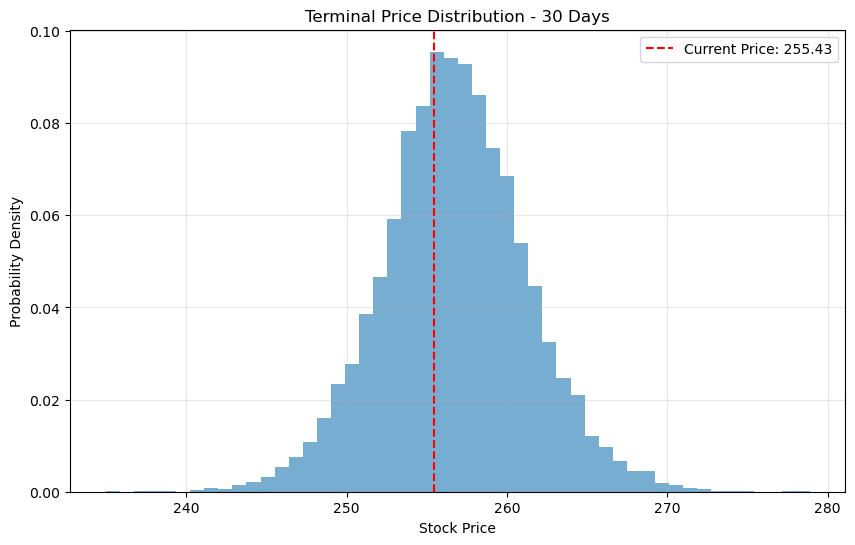

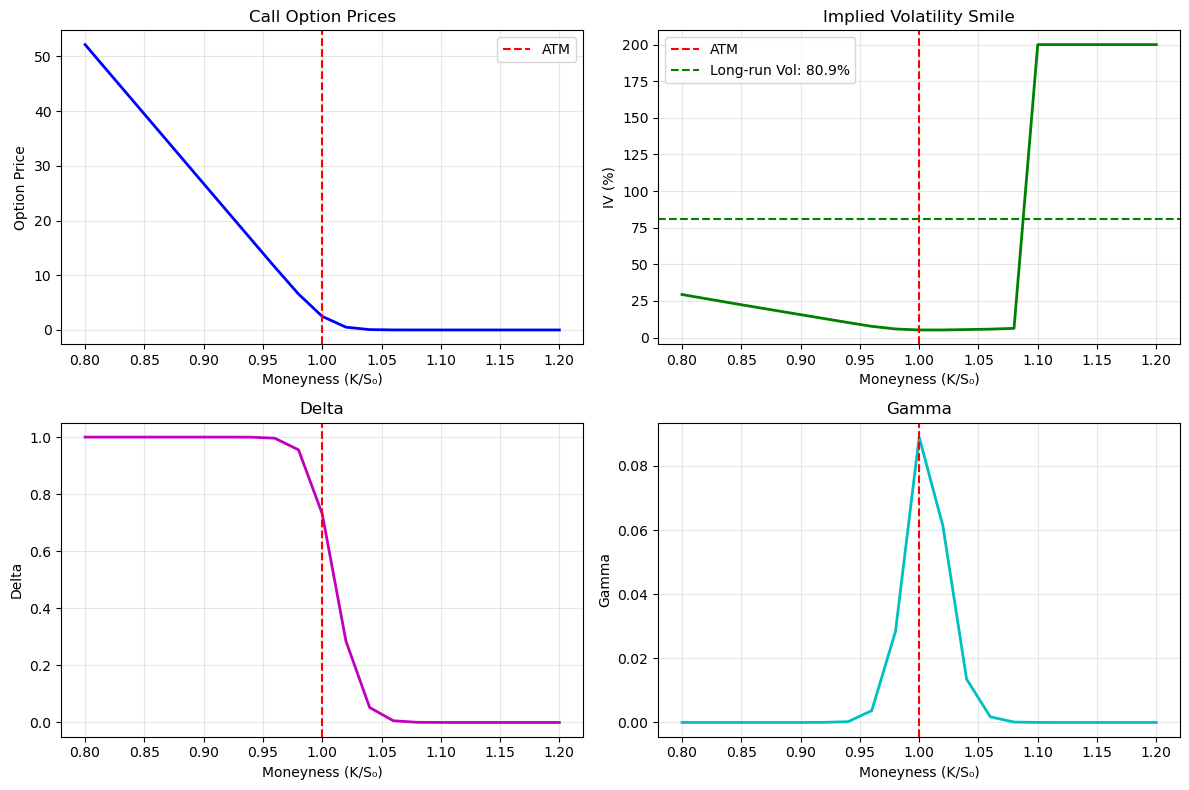

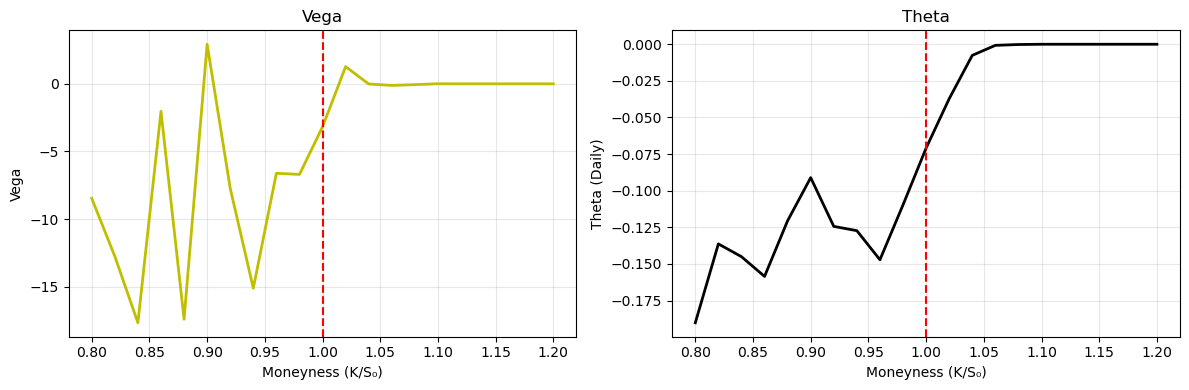

In [210]:
call_options = price_options(
    df=df,
    param_estimates=param_estimates,
    option_type='call',
    strike_range=0.2,  # +-% around spot
    strikes_count=21,  # #of different strikes
    expiry_days=30,
    r=0.04,
    q=0.0,
    N_sims=10000,
    plot=True
)

In [211]:
call_options

,strike,moneyness,price,delta,gamma,vega,theta,implied_vol,option_type,expiry_days,spot,risk_free_rate,dividend_yield
0,204.343994,0.80,52.154467,1.000383,0.000000e+00,-8.464686,-0.190168,0.293593,call,30,255.429993,0.04,0.0
1,209.452594,0.82,47.070136,1.000383,-1.089046e-15,-12.747852,-0.136313,0.265411,call,30,255.429993,0.04,0.0
2,214.561194,0.84,41.985805,1.000383,-1.089046e-15,-17.661649,-0.145024,0.237637,call,30,255.429993,0.04,0.0
3,219.669794,0.86,36.901474,1.000383,-1.089046e-15,-2.031219,-0.158506,0.210203,call,30,255.429993,0.04,0.0
4,224.778394,0.88,31.817143,1.000383,-5.445232e-16,-17.398582,-0.120473,0.183033,call,30,255.429993,0.04,0.0
5,229.886993,0.90,26.732812,1.000383,-1.633570e-15,2.923977,-0.091064,0.156034,call,30,255.429993,0.04,0.0
6,234.995593,0.92,21.648483,1.000382,3.549996e-05,-7.721428,-0.124344,0.129082,call,30,255.429993,0.04,0.0
7,240.104193,0.94,16.565222,1.000077,2.412515e-04,-15.106562,-0.127281,0.102183,call,30,255.429993,0.04,0.0
8,245.212793,0.96,11.493603,0.996545,3.686912e-03,-6.610056,-0.147127,0.076330,call,30,255.429993,0.04,0.0
9,250.321393,0.98,6.561992,0.955726,2.831750e-02,-6.694786,-0.109655,0.058468,call,30,255.429993,0.04,0.0
